<h1>Sentiment Analysis project<h1>
<h3>Name student1: Ashiera Preston<h3>
<h3>Name student2: Donovan Hood<h3>
<h3>Name student2: Xavier Thomas<h3>

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hazel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Printing first 10 rows of customer_review.tsv
   rating       date             variation  \
0       5  31-Jul-18      Charcoal Fabric    
1       5  31-Jul-18      Charcoal Fabric    
2       4  31-Jul-18        Walnut Finish    
3       5  31-Jul-18      Charcoal Fabric    
4       5  31-Jul-18      Charcoal Fabric    
5       5  31-Jul-18  Heather Gray Fabric    
6       3  31-Jul-18     Sandstone Fabric    
7       5  31-Jul-18      Charcoal Fabric    
8       5  30-Jul-18  Heather Gray Fabric    
9       5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
5  I received the echo as a gift. I needed anothe...     

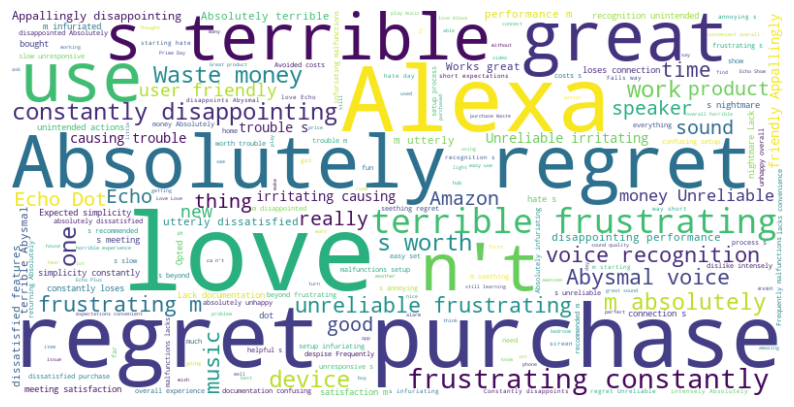

Training set: 0                                                  [3, 5]
1                                                   [247]
2       [258, 172, 304, 543, 705, 10, 360, 103, 544, 4...
3       [164, 72, 113, 298, 209, 814, 168, 139, 50, 32...
4                                                    [14]
                              ...                        
5395                                    [2, 62, 4, 9, 11]
5396                 [12, 126, 41, 23, 37, 1, 109, 1, 21]
5397                  [63, 67, 78, 18, 75, 2, 79, 32, 49]
5398                            [13, 8, 1, 17, 7, 12, 18]
5399                [132, 59, 123, 124, 101, 38, 129, 44]
Name: review_sequences, Length: 5400, dtype: object
Training set shape: (4320, 10) (4320, 2)
Testing set shape: (1080, 10) (1080, 2)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 10, 120)           120000

In [17]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# One-time setup steps
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#-----------------------------
#--------Data Wrangling--------
#-----------------------------
#Step 1: Read the data
file_path = "../dataset/customer_review.tsv"
df = pd.read_csv(file_path, sep='\t')

#Step 2: Print the first 10 lines
print("Printing first 10 rows of customer_review.tsv")
print(df.head(10))

#Step 3: Verify that data does not contain missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

missing_rows = df[df.isnull().any(axis=1)]

# Print the lines with missing values
for index, row in missing_rows.iterrows():
    print(f"Line {index + 1}:", "\t".join(map(str, row)))

#Step 4: Remove stop words
def remove_stopwords(review):
    # Check if the review is not NaN
    if isinstance(review, str):
        words = nltk.word_tokenize(review)
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)
    else:
        return ''  # Return an empty string for NaN values

df['cleaned_reviews'] = df['verified_reviews'].apply(remove_stopwords)

#Step 5: Generate word cloud
def generate_wordcloud(text):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(text)

    # Plot the WordCloud image                        
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

cleaned_text = ' '.join(df['cleaned_reviews'].values)
generate_wordcloud(cleaned_text)

#--------------------------------
#--------Data Engineering--------
#--------------------------------
#Step 1: Encode target labels (feedback)
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['feedback'])

#Step 2: Tokenizing reviews
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df['cleaned_reviews'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_reviews'])

# Add a new column with the sequences
df['review_sequences'] = sequences

#-------------------------------------------------
#--------Data Splitting (Training/Testing)--------
#-------------------------------------------------
X = df['review_sequences']
y = df['encoded_labels']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
maxlen = 10
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#----------------------------
#--------Model Design--------
#----------------------------
vocab_size = 1000
embedding_dim = 120
lstm_units = 176
dropout_rate = 0.2
recurrent_dropout_rate = 0.2

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

#----------------------------------
#--------Training the Model--------
#----------------------------------
max_index = np.max(X_train)
print("Maximum index in sequences:", max_index)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose='auto', validation_split=0.2)

#------------------------------------
#--------Evaluating the Model--------
#------------------------------------
predictions_prob = model.predict(X_test)

# Step 2: Use argmax from NumPy to transform the predicted labels
predicted_labels = np.argmax(predictions_prob, axis=1)

# Transform the true labels (y_test) using argmax
true_labels = np.argmax(y_test, axis=1)

#--------------------------------------
#--------Performance Evaluation--------
#--------------------------------------
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

classification_report_result = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", classification_report_result)

confusion_matrix_result = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", confusion_matrix_result)

In [18]:
import tkinter as tk
from tkinter import messagebox

# Your existing functions and imports
# (Assuming you have already defined remove_stopwords, tokenizer, pad_sequences, model, and maxlen)

def classify_review():
    review = entry.get()
    if review:
        cleaned_user_review = remove_stopwords(review)
        user_sequences = tokenizer.texts_to_sequences([cleaned_user_review])
        user_input_padded = pad_sequences(user_sequences, maxlen=maxlen)
        prediction_prob = model.predict(user_input_padded)[0]
        predicted_label = np.argmax(prediction_prob)

        if predicted_label == 1:
            result_label.config(text="Model Prediction: Positive review!")
        else:
            result_label.config(text="Model Prediction: Negative review.")
    else:
        messagebox.showwarning("Warning", "Please enter a review.")

# GUI setup
root = tk.Tk()
root.title("Review Classifier")

# Entry for user input
entry = tk.Entry(root, width=40)
entry.pack(pady=10)

# Button to classify review
classify_button = tk.Button(root, text="Classify Review", command=classify_review)
classify_button.pack(pady=10)

# Label to display model prediction
result_label = tk.Label(root, text="")
result_label.pack(pady=10)

# Button to exit the GUI
exit_button = tk.Button(root, text="Exit", command=root.destroy)
exit_button.pack(pady=10)

# Start the GUI main loop
root.mainloop()

1/1 [==============================] - 0s 20ms/step
